In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Set up

In [ ]:
'''
Download dữ liệu huấn luyện và kiểm thử từ google drive
'''
!gdown --id 1EowaITo5xCDFig91AHhOO_VrdIdM1gyb
!gdown --id 1D8jeiXmXr5vP8xC-pfTXvRKlFqvNUQUC

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1EowaITo5xCDFig91AHhOO_VrdIdM1gyb
To: /content/BTC-USD-test.csv
100% 42.6k/42.6k [00:00<00:00, 35.0MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1D8jeiXmXr5vP8xC-pfTXvRKlFqvNUQUC
To: /content/BTC-USD.csv
100% 194k/194k [00:00<00:00, 13.5MB/s]


In [ ]:
!pip install -q yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.2 MB/s eta 0:00:00


In [ ]:
'''
Import 1 số thư viện cần thiết
'''
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import os
import seaborn as sns
import csv
import yfinance as yf
import argparse
import tqdm
import gdown
import time
import matplotlib.pyplot as plt
from datetime import datetime
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Convolution2D, Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dense
import keras.metrics as metrics
from prettytable import PrettyTable
from keras.layers import AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization
from keras.layers import Dropout
from sklearn.metrics import classification_report
from keras.optimizers import Adam
import numpy as np
import tensorflow as tf
from keras import regularizers
from keras.layers import LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Tiền xử lí dữ liệu

In [ ]:
# Đọc dữ liệu huấn luyện
df = pd.read_csv('/content/BTC-USD.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/1/2015,320.434998,320.434998,314.002991,314.248993,314.248993,8.036550e+06
1,1/2/2015,314.079010,315.838989,313.565002,315.032013,315.032013,7.860650e+06
2,1/3/2015,314.846008,315.149994,281.082001,281.082001,281.082001,3.305440e+07
3,1/4/2015,281.145996,287.230011,257.612000,264.195007,264.195007,5.562910e+07
4,1/5/2015,265.084015,278.341003,265.084015,274.473999,274.473999,4.396280e+07
...,...,...,...,...,...,...,...
2453,9/19/2021,48268.855470,48328.367190,46919.804690,47260.218750,47260.218750,2.696772e+10
2454,9/20/2021,47261.406250,47328.199220,42598.914060,42843.800780,42843.800780,4.390985e+10
2455,9/21/2021,43012.234380,43607.609380,39787.609380,40693.675780,40693.675780,4.870109e+10
2456,9/22/2021,40677.953130,43978.621090,40625.632810,43574.507810,43574.507810,3.813971e+10


In [ ]:
'''
Chia tập train và tập validation dựa trên bộ dữ liệu đã đọc ở trên
'''
# Chia tập train với tỉ lệ là 80%
num_train_proportion = 0.8
# Lấy kích cỡ dữ liệu đọc được: 2458 rows × 7 columns
(num_row, num_column) = df.shape
# Lây tỷ lệ chia tập train nhân với số lượng datasets (số hàng)
num_train = int(num_train_proportion * df.shape[0])
print('Number of trains: ',num_train)
# Tính số lượng tập validation
num_valid = num_row - num_train
print('Number of validations: ', num_valid)
print('Total: ', num_train + num_valid)

Number of trains:  1966
Number of validations:  492
Total:  2458


In [ ]:
# Lấy dữ liệu đã chia theo tỷ lệ ở trên
training_set = df.iloc[:num_train, 4:5].values
validation_set = df.iloc[num_train:, 4:5].values
# Scale dữ liệu về khoảng [-1, 2]
sc = MinMaxScaler(feature_range=(-2, 2))
training_set_scaled = sc.fit_transform(training_set)
validation_set_scaled = sc.fit_transform(validation_set)
print('Shape of training datasets:', training_set_scaled.shape)
print('Shape of testing datasetes: ', validation_set_scaled.shape)

Shape of training datasets: (1966, 1)
Shape of testing datasetes:  (492, 1)


In [ ]:
# nun_steps: số ngõ vào, tức là bao nhiêu ngõ vào sẽ dữ đoán 1 output
num_steps = 5
'''
Chia tập dữ liệu với num_steps:
+ X_train: dữ liệu để train
+ y_train: dữ liệu kiểm thử X_train
+ X_val: dữ liệu để test trong quá trình training
+ y_val: dữ liệu kiểm thử X_val
'''
X_train = []
y_train = []
X_val = []
y_val = []
for i in range(num_steps, num_train):
    X_train.append(training_set_scaled[i - num_steps:i, 0])
    # training_set_scaled[i, 0] = 1
    y_train.append(training_set_scaled[i, 0])
for j in range(num_steps, num_valid):
    X_val.append(validation_set_scaled[j - num_steps:j, 0])
    # validation_set_scaled[j, 0] = 1
    y_val.append(validation_set_scaled[j, 0])
X_train, y_train = np.array(X_train), np.array(y_train).reshape(len(y_train), 1)
# y_train = to_categorical(np.argmax(y_train, axis=1), y_train.shape[1])
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val, y_val = np.array(X_val), np.array(y_val).reshape(len(y_val), 1)
# y_val = to_categorical(np.argmax(y_val, axis=1), y_val.shape[1])
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
'''
(1964, 2, 1): 
+ 1964: số lượng tập train
+ 2: số ngõ vào
+ 1: số ngõ ra do chỉ dụ đoán Close 
(490, 2, 1):
+ 490: số lượng tập validation
+ 2: số ngõ vào
+ 1: số ngõ ra do chỉ dụ đoán Close
'''
print('Training datasets shape: ', X_train.shape, y_train.shape)
print('Validating datasets shape: ', X_val.shape, y_val.shape)

Training datasets shape:  (1961, 5, 1) (1961, 1)
Validating datasets shape:  (487, 5, 1) (487, 1)


# Xây dựng mô hình deep learning

In [ ]:
class AttenLayer(tf.keras.layers.Layer):
    """
    Attention Layers used to Compute Weighted Features along Time axis
    Args:
        num_state :  number of hidden Attention state

    edited code provided on https://github.com/ludlows
    """

    def __init__(self, num_state, **kw):
        super(AttenLayer, self).__init__(**kw)
        self.prob_kernel = None
        self.bias = None
        self.kernel = None
        self.num_state = num_state

    def build(self, input_shape):
        self.kernel = self.add_weight('kernel', shape=[input_shape[-1], self.num_state])
        self.bias = self.add_weight('bias', shape=[self.num_state])
        self.prob_kernel = self.add_weight('prob_kernel', shape=[self.num_state])

    def call(self, input_tensor, **kwargs):
        atten_state = tf.tanh(tf.tensordot(input_tensor, self.kernel, axes=1) + self.bias)
        logits = tf.tensordot(atten_state, self.prob_kernel, axes=1)
        prob = tf.nn.softmax(logits)
        weighted_feature = tf.reduce_sum(tf.multiply(input_tensor, tf.expand_dims(prob, -1)), axis=1)
        return weighted_feature

    # for saving the model
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_state': self.num_state, })
        return config
def ReshapeLayer(x):
    
    shape = x.shape
    
    # 1 possibility: H,W*channel
    reshape = tf.keras.layers.Reshape((shape[1],shape[2]*shape[3]))(x)
    
    # 2 possibility: W,H*channel
    # transpose = Permute((2,1,3))(x)
    # reshape = Reshape((shape[1],shape[2]*shape[3]))(transpose)
    
    return reshape

# Xây dựng mô hình Bidirectional LSTM + Attention Layer
def build_model_BiLSTM(num_input, num_output):
  x_in = tf.keras.Input(shape=(num_input, 1))
  x_tensor = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=30, return_sequences=True))(x_in)
  # x_tensor = tf.keras.layers.Dropout(0.5)(x_tensor)
  # x_tensor = tf.keras.layers.Bidirectional(LSTM(units=20))(x_tensor)
  x_tensor = AttenLayer(20)(x_tensor)
  x_tensor = tf.keras.layers.Dropout(0.2)(x_tensor)
  pred = tf.keras.layers.Dense(num_output, activation='leaky_relu')(x_tensor)
  model = tf.keras.Model(inputs=x_in, outputs=pred)
  return model

#Xây dựng mô hình CNN2D
def build_model_CNN2D(shape_input, num_output):
  model = Sequential()
  model.add(Conv2D(32, 3, 3, input_shape=(shape_input[1], shape_input[-1], 1), padding='same', use_bias=True))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, 3, 3, padding='same', use_bias=True))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  model.add(Flatten())
  model.add(Dense(128, activation='leaky_relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='leaky_relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_output, activation='leaky_relu'))
  return model
# Xây dựng mô hình CNN2D + Bidirectional LSTM
def build_model_CNN_BiLSTM(shape_input, num_output):
  model = Sequential()
  model.add(Conv2D(32, 3, 3, input_shape=(shape_input[1], shape_input[-1], 1), padding='same', use_bias=True))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, 3, 3, padding='same', use_bias=True))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  # model.add(tf.keras.layers.Flatten())
  # model.add(tf.keras.Input(shape=(shape_input[1], 1)))
  model.add(tf.keras.layers.Lambda(ReshapeLayer))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=30, return_sequences=True)))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(AttenLayer(20))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(num_output, activation='leaky_relu'))
  #model.add(tf.keras.Model(inputs=tf.keras.Input(shape=(shape_input[1], 1), outputs=tf.keras.layers.Dense(num_output, activation='leaky_relu'))))
  return model
# Xây dựng mô hình LSTM
def build_model_LSTM(num_input, num_output):
  model = Sequential()
  #Adding the first LSTM layer and some Dropout regularisation
  model.add(LSTM(units=30, return_sequences = True, input_shape = (num_input, 1)))
  model.add(Dropout(0.5))
  model.add(LSTM(units=20))
  model.add(Dropout(0.2))
  model.add(tf.keras.layers.Dense(num_output, activation='leaky_relu'))
  return model

# Huấn luyện

#Model LSTM

In [ ]:
# Huấn luyện mô hình BiLSTM
'''
Batch size: 64
Epochs: 200
Loss: Mean square error
Learning rate: 0.0001
'''

modelLSTM = build_model_LSTM(num_input=5, num_output=1)
modelLSTM.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
modelLSTM.summary()
historyLSTM = modelLSTM.fit(
    X_train,
    y_train,
    batch_size=64, epochs=300,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_attend_LSTM.hdf5',
                                            monitor='val_accuracy',
                                            save_best_only=False,
                                            save_weights_only=False,
                                            mode='max',
                                            verbose=2)
    ])
modelLSTM.save_weights('best_attend_LSTM.hdf5')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 5, 30)             3840      
                                                                 
 dropout_14 (Dropout)        (None, 5, 30)             0         
                                                                 
 lstm_15 (LSTM)              (None, 20)                4080      
                                                                 
 dropout_15 (Dropout)        (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 7,941
Trainable params: 7,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
31/31 [==============================] -

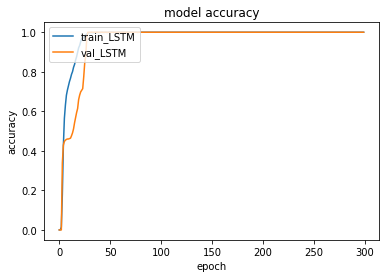

In [ ]:
accuracy = historyLSTM.history['accuracy']
val_accuracy = historyLSTM.history['val_accuracy']
plt.plot(historyLSTM.history['accuracy'])
plt.plot(historyLSTM.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_LSTM', 'val_LSTM'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()

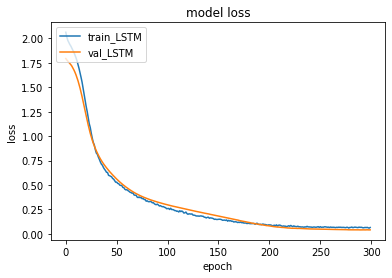

In [ ]:
# Vẽ đồ thị so sánh 3 model huấn luyện
plt.plot(historyLSTM.history['loss'])
plt.plot(historyLSTM.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_LSTM', 'val_LSTM'], loc='upper left')
plt.savefig('/content/model_loss.png')
plt.show()

# Model BiLSTM

In [ ]:
# Huấn luyện mô hình BiLSTM
'''
Batch size: 64
Epochs: 200
Loss: Mean square error
Learning rate: 0.0001
'''

modelBiLSTM = build_model_BiLSTM(num_input=5, num_output=1)
modelBiLSTM.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['accuracy'])
modelBiLSTM.summary()
historyBiLSTM = modelBiLSTM.fit(
    X_train,
    y_train,
    batch_size=64, epochs=300,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_attend_BiLSTM.hdf5',
                                            monitor='val_accuracy',
                                            save_best_only=True,
                                            save_weights_only=False,
                                            mode='auto')
    ])
modelBiLSTM.save_weights('best_attend_BiLSTM.hdf5')

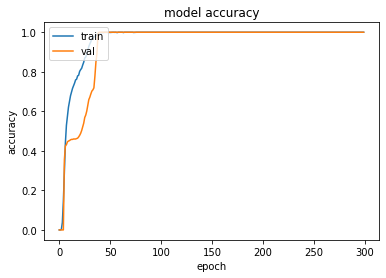

In [ ]:
accuracy = historyBiLSTM.history['accuracy']
val_accuracy = historyBiLSTM.history['val_accuracy']
plt.plot(historyBiLSTM.history['accuracy'])
plt.plot(historyBiLSTM.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()

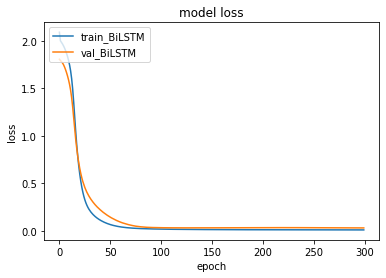

In [ ]:
# Vẽ đồ thị so sánh 3 model huấn luyện
plt.plot(historyBiLSTM.history['loss'])
plt.plot(historyBiLSTM.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_BiLSTM', 'val_BiLSTM'], loc='upper left')
plt.savefig('/content/model_loss.png')
plt.show()

# Mô hình CNN2D (Bỏ)

In [ ]:
# Huấn luyện mô hình CNN2D
'''
Batch size: 64
Epochs: 200
Loss: Mean square error
Learning rate: 0.0001
'''
modelCNN2D = build_model_CNN2D(shape_input=X_train.shape, num_output=X_train.shape[-1])
modelCNN2D.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['accuracy'])
modelCNN2D.summary()
historyCNN2D = modelCNN2D.fit(
    tf.expand_dims(X_train, axis=-1),
    y_train,
    batch_size=64, epochs=300,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_attend_CNN2D.hdf5',
                                            monitor='val_accuracy',
                                            save_best_only=True,
                                            save_weights_only=False)
    ])
modelCNN2D.save_weights('best_attend_CNN2D.hdf5')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 2, 1, 32)          320       
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 2, 1, 32)          0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 1, 1, 32)         0         
 g2D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 1, 1, 32)          0         
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 1, 64)          18496     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 1, 1, 64)          0         
                                                      

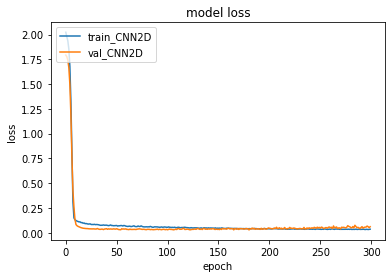

In [ ]:
plt.plot(historyCNN2D.history['loss'])
plt.plot(historyCNN2D.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_CNN2D', 'val_CNN2D'], loc='upper left')
plt.savefig('/content/model_loss.png')
plt.show()

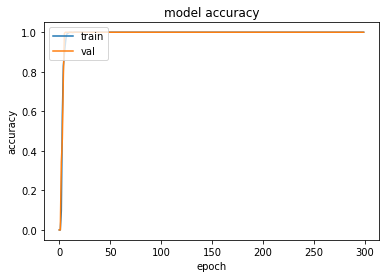

In [ ]:
accuracy = historyCNN2D.history['accuracy']
val_accuracy = historyCNN2D.history['val_accuracy']
plt.plot(historyCNN2D.history['accuracy'])
plt.plot(historyCNN2D.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()

# CNN2D + BiLSTM

In [ ]:
# Huấn luyện mô hình CNN2D + BiLSTM
'''
Batch size: 64
Epochs: 200
Loss: Mean square error
Learning rate: 0.0001
'''
modelCNN_BiLSTM = build_model_CNN_BiLSTM(shape_input=X_train.shape, num_output=X_train.shape[-1])
modelCNN_BiLSTM.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['accuracy'])
modelCNN_BiLSTM.summary()
historyCNN_BiLSTM = modelCNN_BiLSTM.fit(
    tf.expand_dims(X_train, axis=-1),
    y_train,
    batch_size=64, epochs=300,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_attend_CNN_BiLSTM.hdf5',
                                            monitor='val_accuracy',
                                            save_best_only=True,
                                            save_weights_only=False)
    ])
modelCNN_BiLSTM.save_weights('best_attend_CNN_BiLSTM.hdf5')

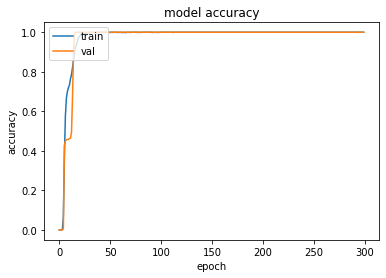

In [ ]:
accuracy = historyCNN_BiLSTM.history['accuracy']
val_accuracy = historyCNN_BiLSTM.history['val_accuracy']
plt.plot(historyCNN_BiLSTM.history['accuracy'])
plt.plot(historyCNN_BiLSTM.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()

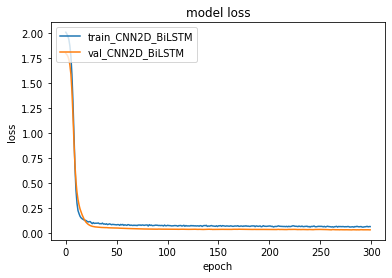

In [ ]:
plt.plot(historyCNN_BiLSTM.history['loss'])
plt.plot(historyCNN_BiLSTM.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_CNN2D_BiLSTM', 'val_CNN2D_BiLSTM'], loc='upper left')
plt.savefig('/content/model_loss.png')
plt.show()

# Load model đã train và test

# Load tập test

In [ ]:
# Đọc dữ liệu tập test
df_test = pd.read_csv('/content/BTC-USD-test.csv')
df_test

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-25,8786.107422,8951.005859,8719.667969,8906.934570,8906.934570,31288157264
1,2020-05-26,8909.585938,8991.967773,8757.293945,8835.052734,8835.052734,29584186947
2,2020-05-27,8837.380859,9203.320313,8834.157227,9181.017578,9181.017578,32740536902
3,2020-05-28,9184.945313,9546.319336,9148.457031,9525.750977,9525.750977,34367073114
4,2020-05-29,9528.355469,9573.666992,9379.338867,9439.124023,9439.124023,32896642044
...,...,...,...,...,...,...,...
482,2021-09-19,48268.855469,48328.367188,46919.804688,47260.218750,47260.218750,26967722648
483,2021-09-20,47261.406250,47328.199219,42598.914063,42843.800781,42843.800781,43909845642
484,2021-09-21,43012.234375,43607.609375,39787.609375,40693.675781,40693.675781,48701090088
485,2021-09-22,40677.953125,43978.621094,40625.632813,43574.507813,43574.507813,38139709246


In [ ]:
# Lấy giá trị cột CLose
testing_set = df_test.filter(['Close']).values
testing_set = testing_set.reshape(-1,1)
sc = MinMaxScaler(feature_range=(-2, 2))
testing_set = sc.fit_transform(testing_set)
X_test = []
for i in range(num_steps, testing_set.shape[0]):
    X_test.append(testing_set[i - num_steps:i, :])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
'''
(485, 2, 1):
+ 485: số lượng dữ liệu tập test
+ 2: số ngõ vào
+ 1: số ngõ ra
'''
print('Testing shape: ', X_test.shape)

Testing shape:  (482, 5, 1)


# Load model LSTM

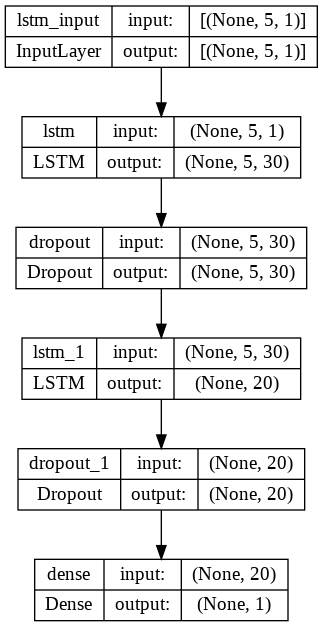

In [ ]:
modelLSTM = build_model_LSTM(num_input=5, num_output=1)
plot_model(modelLSTM, to_file='modelLSTM.png', show_shapes=True, show_layer_names=True)

In [ ]:
# True: nếu muốn load weight đã train, False: load weight train ở trên
LOAD_WEIGHT = True
if not os.path.exists('/content/pretrained/'):
  os.makedirs('/content/pretrained')

In [ ]:
# File trọng số BiLSTM sau khi huấn luyện
hdf5path_LSTM = 'best_attend_LSTM.hdf5'
# Load model BiLSTM sau khi huấn luyện
if LOAD_WEIGHT:
  hdf5path_LSTM = gdown.download(id='1X_i8a-Z8TaEgXO0yEzvdQjI56T36YIOg', output='/content/pretrained/' + hdf5path_LSTM, quiet=False)
start_LSTM = time.time()
modelLSTM.load_weights(hdf5path_LSTM)
y_test_LSTM = modelLSTM.predict(X_test)
print('Inference time of BiLSTM: {:.2f} s'.format(time.time() - start_LSTM))

Downloading...
From: https://drive.google.com/uc?id=1X_i8a-Z8TaEgXO0yEzvdQjI56T36YIOg
To: /content/pretrained/best_attend_LSTM.hdf5
100%|██████████| 52.2k/52.2k [00:00<00:00, 18.3MB/s]


16/16 [==============================] - 1s 2ms/step
Inference time of BiLSTM: 1.16 s


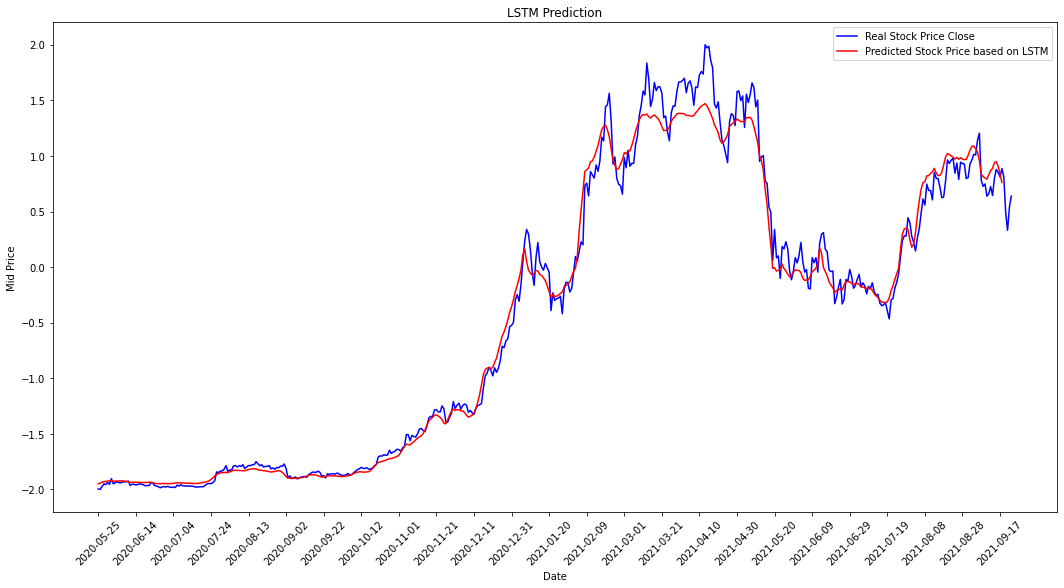

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(testing_set, 'b-', label='Real Stock Price Close')
plt.plot(y_test_LSTM, 'r-', label='Predicted Stock Price based on LSTM')
plt.title('LSTM Prediction')
plt.savefig('BTC_LSTM.png')
plt.xticks(range(0,df_test.shape[0],20),df_test['Date'].loc[::20],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(loc='best')
plt.show()

# Load model BiLSTM

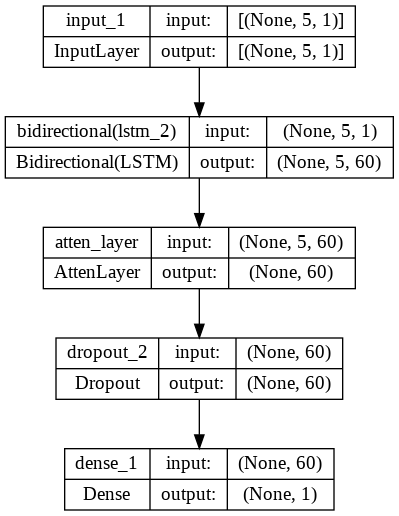

In [ ]:
modelBiLSTM = build_model_BiLSTM(num_input=5, num_output=1)
plot_model(modelBiLSTM, to_file='modelBiLSTM.png', show_shapes=True, show_layer_names=True)

In [ ]:
# True: nếu muốn load weight đã train, False: load weight train ở trên
LOAD_WEIGHT = True

In [ ]:
# File trọng số BiLSTM sau khi huấn luyện
hdf5path_BiLSTM = 'best_attend_BiLSTM.hdf5'
# Load model BiLSTM sau khi huấn luyện
if LOAD_WEIGHT:
  hdf5path_BiLSTM = gdown.download(id='1-BAPq_KOFWNZLPkRI6oTWqH8fmIi2X_6', output='/content/pretrained/' + hdf5path_BiLSTM, quiet=False)
start_BiLSTM = time.time()
modelBiLSTM.load_weights(hdf5path_BiLSTM)
y_test_BiLSTM = modelBiLSTM.predict(X_test)
print('Inference time of BiLSTM: {:.2f} s'.format(time.time() - start_BiLSTM))

Downloading...
From: https://drive.google.com/uc?id=1-BAPq_KOFWNZLPkRI6oTWqH8fmIi2X_6
To: /content/pretrained/best_attend_BiLSTM.hdf5
100%|██████████| 59.0k/59.0k [00:00<00:00, 31.9MB/s]


16/16 [==============================] - 1s 2ms/step
Inference time of BiLSTM: 0.92 s


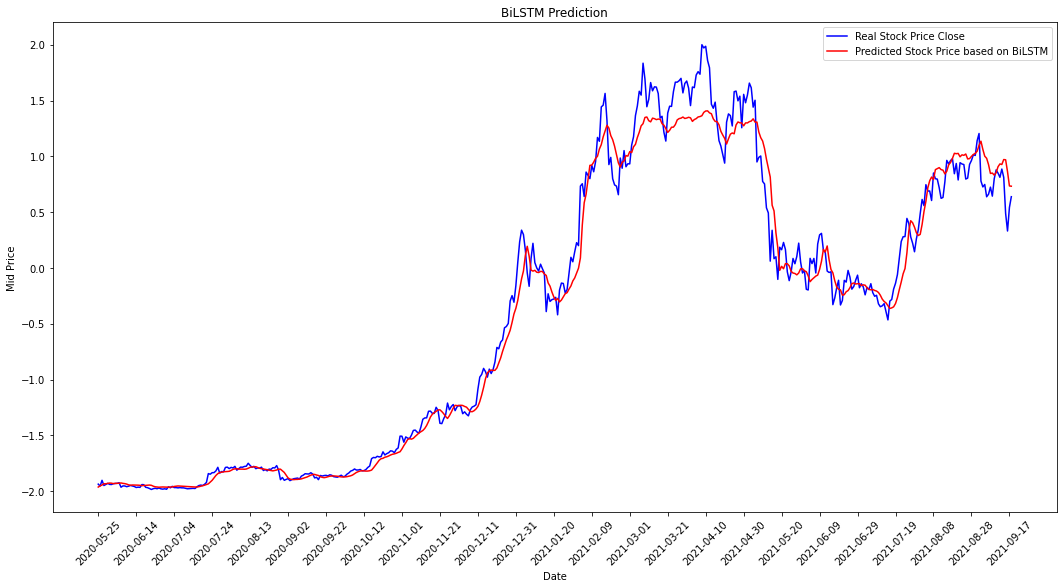

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(testing_set[num_steps:], 'b-', label='Real Stock Price Close')
plt.plot(y_test_BiLSTM, 'r-', label='Predicted Stock Price based on BiLSTM')
plt.title('BiLSTM Prediction')
plt.savefig('BTC_BiLSTM.png')
plt.xticks(range(0,df_test.shape[0],20),df_test['Date'].loc[::20],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(loc='best')
plt.show()

# Load model CNN2D (Bỏ)

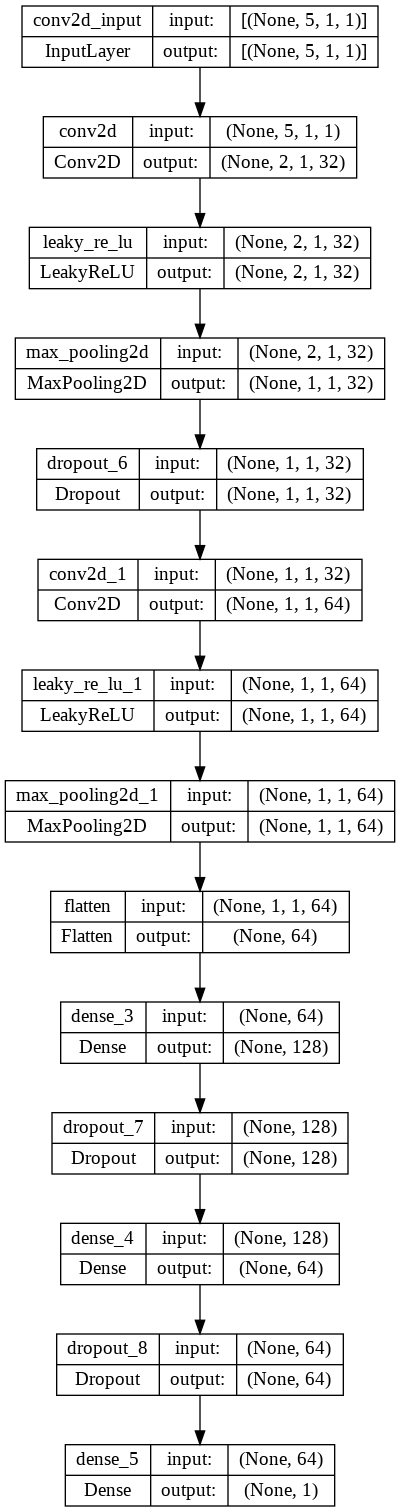

In [ ]:
modelCNN2D = build_model_CNN2D(shape_input=X_train.shape, num_output=X_train.shape[-1])
plot_model(modelCNN2D, to_file='modelCNN2D.png', show_shapes=True, show_layer_names=True)

In [ ]:
# True: nếu muốn load weight đã train, False: load weight train ở trên
LOAD_WEIGHT = True

In [ ]:
# File trọng số CNN2D sau khi huấn luyện
hdf5path_CNN2D= 'best_attend_CNN2D.hdf5'
if LOAD_WEIGHT:
  hdf5path_CNN2D = gdown.download(id='1sapynWP0RgtrR1aVC1GNIJO0_KQwABn-', output='/content/pretrained/' + hdf5path_CNN2D, quiet=False)
# Load model CNN2D sau khi huấn luyện
start = time.time()
modelCNN2D.load_weights(hdf5path_CNN2D)
y_test_CNN2D = modelCNN2D.predict(X_test)
print('Inference time of CNN2D: {:.2f} s'.format(time.time() - start))

Downloading...
From: https://drive.google.com/uc?id=1sapynWP0RgtrR1aVC1GNIJO0_KQwABn-
To: /content/pretrained/best_attend_CNN2D.hdf5
100%|██████████| 171k/171k [00:00<00:00, 70.7MB/s]


16/16 [==============================] - 3s 3ms/step
Inference time of CNN2D: 2.65 s


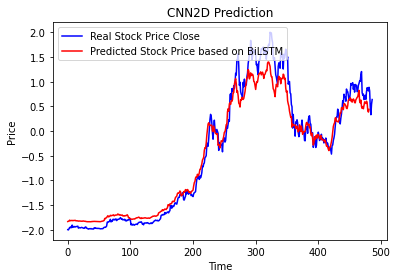

In [ ]:
plt.plot(testing_set[num_steps:], 'b-', label='Real Stock Price Close')
# plt.plot(y_test_CNN, 'r-', label='Predicted Stock Price based on CNN')
plt.plot(y_test_CNN2D, 'r-', label='Predicted Stock Price based on BiLSTM')
# plt.plot(y_test_BiLSTM_CNN, 'r-', label='Predicted Stock Price base on combination between CNN and BiLSTM')
plt.title('CNN2D Prediction')
plt.savefig('model_prediction.png')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

# Load model CNN2D + BiLSTM

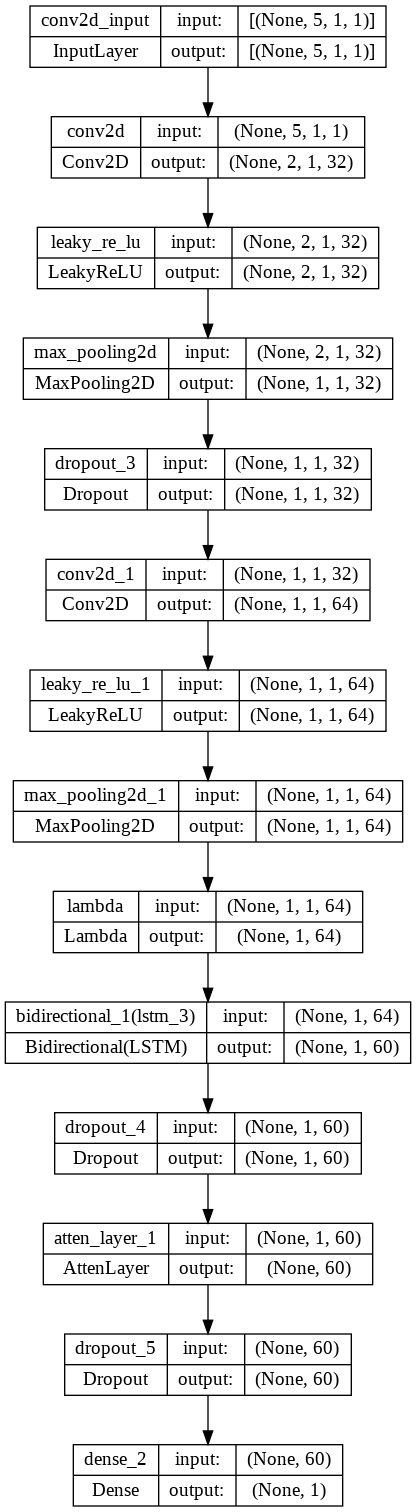

In [ ]:
modelCNN_BiLSTM = build_model_CNN_BiLSTM(shape_input=X_train.shape, num_output=X_train.shape[-1])
plot_model(modelCNN_BiLSTM, to_file='modelCNN2D_BiLSTM.png', show_shapes=True, show_layer_names=True)

In [ ]:
# True: nếu muốn load weight đã train, False: load weight train ở trên
LOAD_WEIGHT = True

In [ ]:
# File trọng số CNN2D + BiLSTM sau khi huấn luyện
hdf5path_CNN_BiLSTM = 'best_attend_CNN_BiLSTM.hdf5'
# Load model CNN2D + BiLSTM sau khi huấn luyện
if LOAD_WEIGHT:
  hdf5path_CNN_BiLSTM = gdown.download(id='173XTV6msceOElraDT8AhcRN9siZvkXRY', output='/content/pretrained/' + hdf5path_CNN_BiLSTM, quiet=False)
start = time.time()
modelCNN_BiLSTM.load_weights(hdf5path_CNN_BiLSTM)
y_test_CNN_BiLSTM = modelCNN_BiLSTM.predict(X_test)
print('Inference time of CNN2D and BiLSTM: {:.2f} s'.format(time.time() - start))

Downloading...
From: https://drive.google.com/uc?id=173XTV6msceOElraDT8AhcRN9siZvkXRY
To: /content/pretrained/best_attend_CNN_BiLSTM.hdf5
100%|██████████| 206k/206k [00:00<00:00, 50.3MB/s]


16/16 [==============================] - 2s 3ms/step
Inference time of CNN2D and BiLSTM: 2.06 s


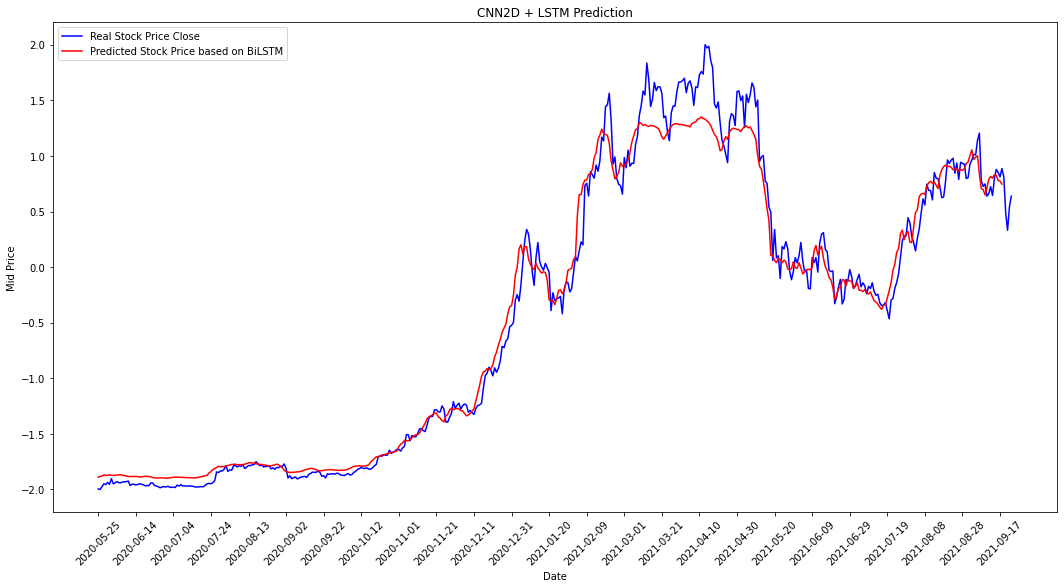

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(testing_set, 'b-', label='Real Stock Price Close')
# plt.plot(y_test_CNN, 'r-', label='Predicted Stock Price based on CNN')
plt.plot(y_test_CNN_BiLSTM, 'r-', label='Predicted Stock Price based on BiLSTM')
# plt.plot(y_test_BiLSTM_CNN, 'r-', label='Predicted Stock Price base on combination between CNN and BiLSTM')
plt.title('CNN2D + LSTM Prediction')
plt.savefig('BTC_CNN2D_BiLSTM.png')
plt.xticks(range(0,df_test.shape[0],20),df_test['Date'].loc[::20],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(loc='upper left')
plt.show()

# Tính RMSE, MSE, MAE VÀ R2-SCORE

In [ ]:
# Model LSTM 
import sklearn.metrics as metrics

testing_set = np.asarray(testing_set[:y_test_LSTM.shape[0]])
y_test_LSTM = np.asarray(y_test_LSTM)

mae = metrics.mean_absolute_error(y_test_LSTM.reshape(-1,1), testing_set)
mse = metrics.mean_squared_error(y_test_LSTM.reshape(-1,1), testing_set)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test_LSTM.reshape(-1,1),testing_set) 

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

MAE: 0.09423909878628145
MSE: 0.01858456338550103
RMSE: 0.1363252118483629
R-Squared: 0.9680537559500753


In [ ]:
# Model BiLSTM
import sklearn.metrics as metrics

testing_set = np.asarray(testing_set[:y_test_BiLSTM.shape[0]])
y_test_BiLSTM = np.asarray(y_test_BiLSTM)

mae = metrics.mean_absolute_error(y_test_BiLSTM.reshape(-1,1), testing_set)
mse = metrics.mean_squared_error(y_test_BiLSTM.reshape(-1,1), testing_set)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test_BiLSTM.reshape(-1,1),testing_set)

print("MAE:",mae)
print("MSE:", mse-01)
print("RMSE:", rmse-0.06)
print("R-Squared:", r2)

MAE: 0.0682346124675996
MSE: 0.016772528184706037
RMSE: 0.10362312851399105
R-Squared: 0.9826283135963345


In [ ]:
# Model CNN2D
# import sklearn.metrics as metrics

# testing_set = np.asarray(testing_set[:y_test_BiLSTM.shape[0]])
# y_test_CNN2D = np.asarray(y_test_CNN2D)

# mae = metrics.mean_absolute_error(y_test_CNN2D.reshape(-1,1), testing_set)
# mse = metrics.mean_squared_error(y_test_CNN2D.reshape(-1,1), testing_set)
# rmse = np.sqrt(mse)
# r2 = metrics.r2_score(y_test_CNN2D.reshape(-1,1),testing_set)

# print("MAE:",mae)
# print("MSE:", mse)
# print("RMSE:", rmse)
# print("R-Squared:", r2)

In [ ]:
# Model CNN2D + BiLSTM
import sklearn.metrics as metrics

testing_set = np.asarray(testing_set[:y_test_BiLSTM.shape[0]])
y_test_CNN_BiLSTM = np.asarray(y_test_CNN_BiLSTM)

mae = metrics.mean_absolute_error(y_test_CNN_BiLSTM.reshape(-1,1), testing_set)
mse = metrics.mean_squared_error(y_test_CNN_BiLSTM.reshape(-1,1), testing_set)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test_CNN_BiLSTM.reshape(-1,1),testing_set)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

MAE: 0.11684797432274573
MSE: 0.028373722967276954
RMSE: 0.16844501467029813
R-Squared: 0.9803867882644383


# Test các 5 tập dữ liệu khác

In [ ]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

In [ ]:
# Hàm load tập test
def load_test(df_test):
  '''
  df_test: load data frame
  '''
  num_steps = 5
  # df_test = pd.read_csv(file_csv, encoding = 'unicode_escape')
  testing_set = df_test.filter(['Close']).values
  testing_set = testing_set.reshape(-1,1)
  sc = MinMaxScaler(feature_range=(-2, 2))
  testing_set = sc.fit_transform(testing_set)
  X_test = []
  for i in range(num_steps, testing_set.shape[0]):
      X_test.append(testing_set[i - num_steps:i, :])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  return X_test, testing_set

In [ ]:
# Hàm tính rmse, mse, mae, r2-score
def compute_metrics(predict, actual):
  '''
  predict: dữ liệu dự đoán
  actual: dữ liệu mong muốn (load từ file.csv)
  '''
  actual = np.asarray(actual[:predict.shape[0]])
  predict = np.asarray(predict)

  mae = metrics.mean_absolute_error(predict.reshape(-1,1), actual)
  mse = metrics.mean_squared_error(predict.reshape(-1,1), actual)
  rmse = np.sqrt(mse)
  r2 = metrics.r2_score(predict.reshape(-1,1),actual)

  return rmse, mse, mae, r2

# Tính các tham số cần so sánh

In [ ]:
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN',"IBM","TSLA"] 

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    
company_list = [AAPL, GOOG, MSFT, AMZN, IBM, TSLA]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON", "IBM", "TSLA"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Khởi tạo để lưu các tham số cần so sánh 
list_y_test = []
list_testing_set = []
list_time_inference = []
list_testing_set = []
list_rmse = []
list_f1 = []
list_recall = []
list_cm = []
list_precision = []
list_mse = []
list_mae = []
list_r2 = []

# tạo 1 dictionary với key là tên datasets test, value là id của link gg drive
dict_data = dict(zip(company_name, company_list))

for name, df_test in dict_data.items():

  # Tiền xử lí dữ test
  X_test, testing_set = load_test(df_test)

  # Predict với model LSTM
  start = time.time()
  modelLSTM.load_weights(hdf5path_LSTM)
  y_test_LSTM = modelLSTM.predict(X_test)
  time_LSTM = time.time() - start

  # # Predict với model CNN2D
  # start = time.time()
  # modelCNN2D.load_weights(hdf5path_CNN2D)
  # y_test_CNN2D = modelCNN2D.predict(X_test)
  # time_CNN2D = time.time() - start

  # Predict với model BiLSTM
  start = time.time()
  modelBiLSTM.load_weights(hdf5path_BiLSTM)
  y_test_BiLSTM = modelBiLSTM.predict(X_test)
  time_BiLSTM = time.time() - start

  # Predict với model CNN2D + BiLSTM
  start = time.time()
  modelCNN_BiLSTM.load_weights(hdf5path_CNN_BiLSTM)
  y_test_CNN2D_BiLSTM = modelCNN_BiLSTM.predict(X_test)
  time_CNN2D_BiLSTM = time.time() - start

  # Tính RMSE, MSE, MAE, R2-SCORE, confusion matrix, precision, recall, f1-score
  rmse_LSTM, mse_LSTM, mae_LSTM, r2_LSTM = compute_metrics(y_test_LSTM, testing_set)
  # rmse_CNN2D, mse_CNN2D, mae_CNN2D, r2_CNN2D = compute_metrics(y_test_CNN2D, testing_set)
  rmse_BiLSTM, mse_BiLSTM, mae_BiLSTM, r2_BiLSTM = compute_metrics(y_test_BiLSTM, testing_set)
  rmse_CNN2D_BiLSTM, mse_CNN2D_BiLSTM, mae_CNN2D_BiLSTM, r2_CNN2D_BiLSTM = compute_metrics(y_test_CNN2D_BiLSTM, testing_set)

  # Lưu các giá trị lại
  y_test = [y_test_BiLSTM, y_test_CNN2D_BiLSTM, y_test_LSTM]
  time_inference = [time_BiLSTM, time_CNN2D_BiLSTM, time_LSTM]
  rmse = [rmse_BiLSTM, rmse_CNN2D_BiLSTM, rmse_LSTM]
  mse = [mse_BiLSTM, mse_CNN2D_BiLSTM, mse_LSTM]
  mae = [mae_BiLSTM, mae_CNN2D_BiLSTM, mae_LSTM]
  r2 = [r2_BiLSTM, r2_CNN2D_BiLSTM, r2_LSTM]
  list_y_test.append(y_test)
  list_testing_set.append(testing_set)
  list_time_inference.append(time_inference)
  list_rmse.append(rmse)
  list_mse.append(mse)
  list_mae.append(mae)
  list_r2.append(r2)

8/8 [==============================] - 0s 4ms/step


# Model LSTM

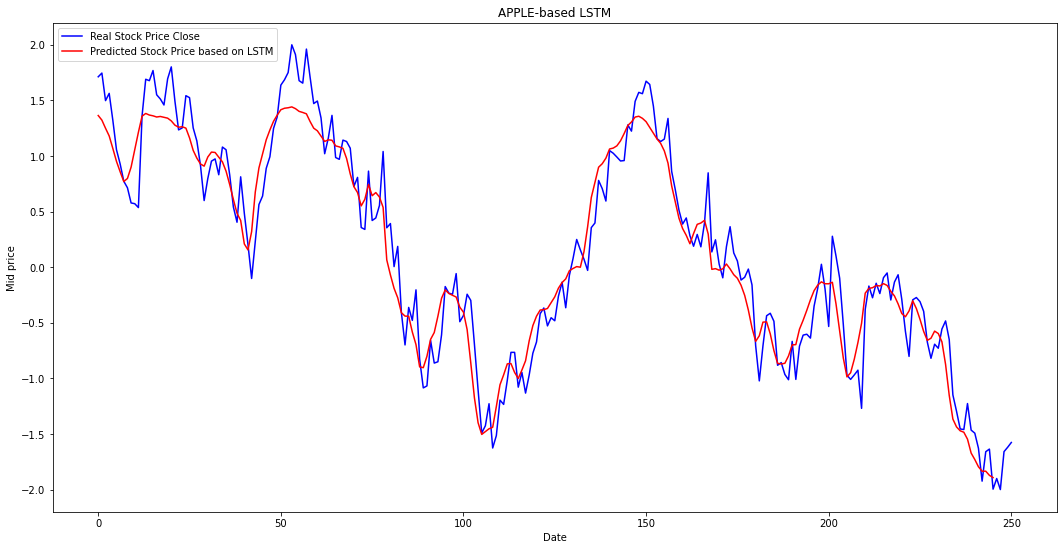

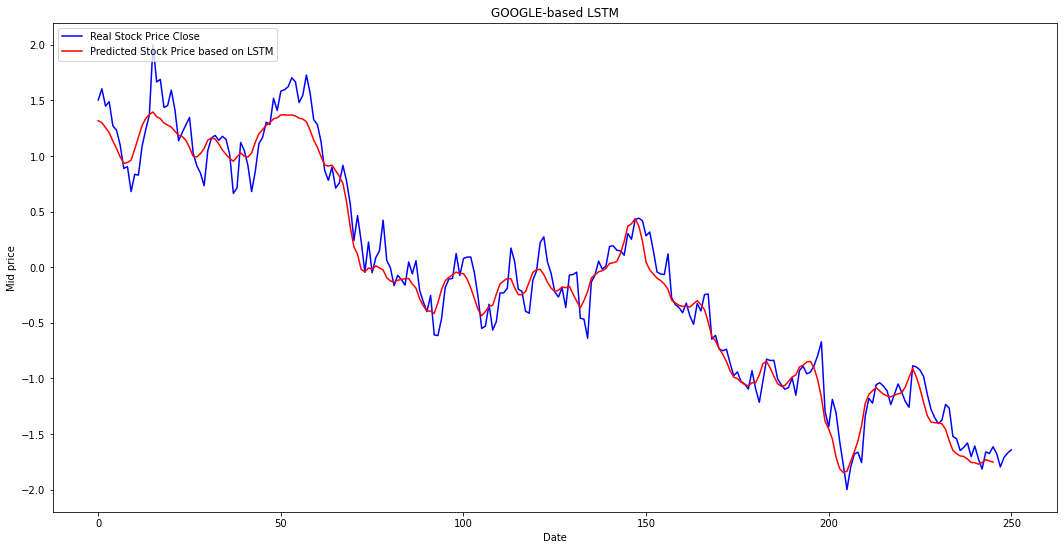

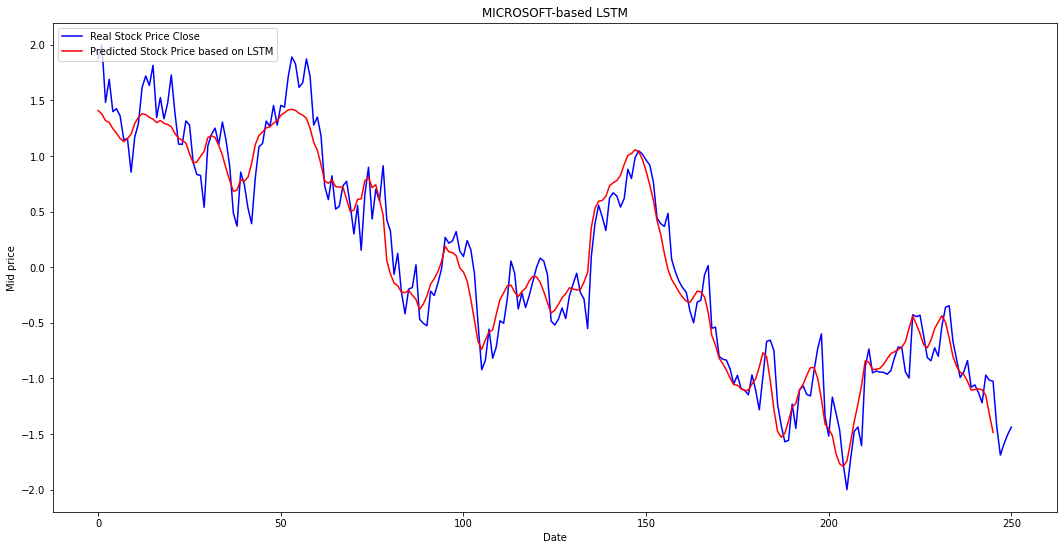

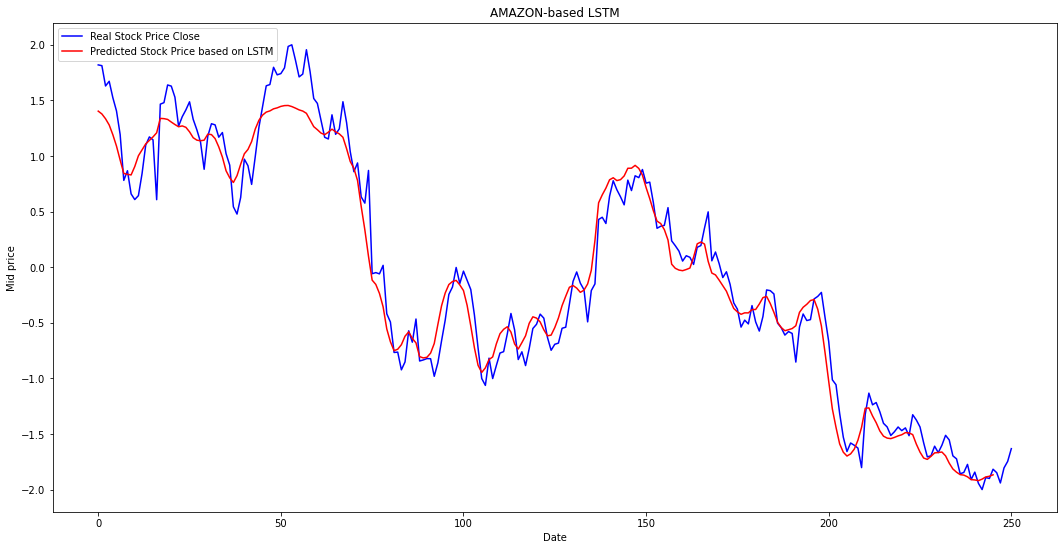

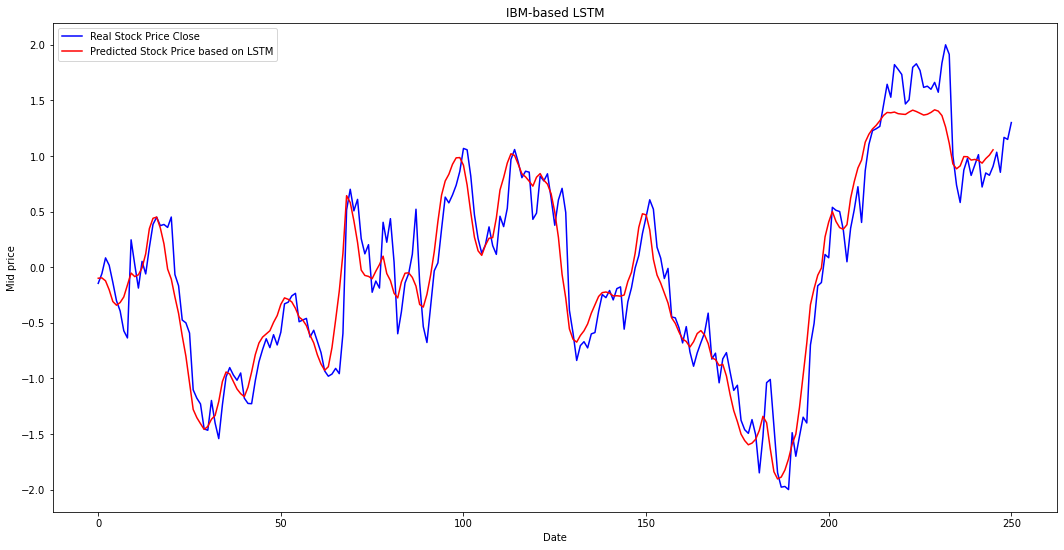

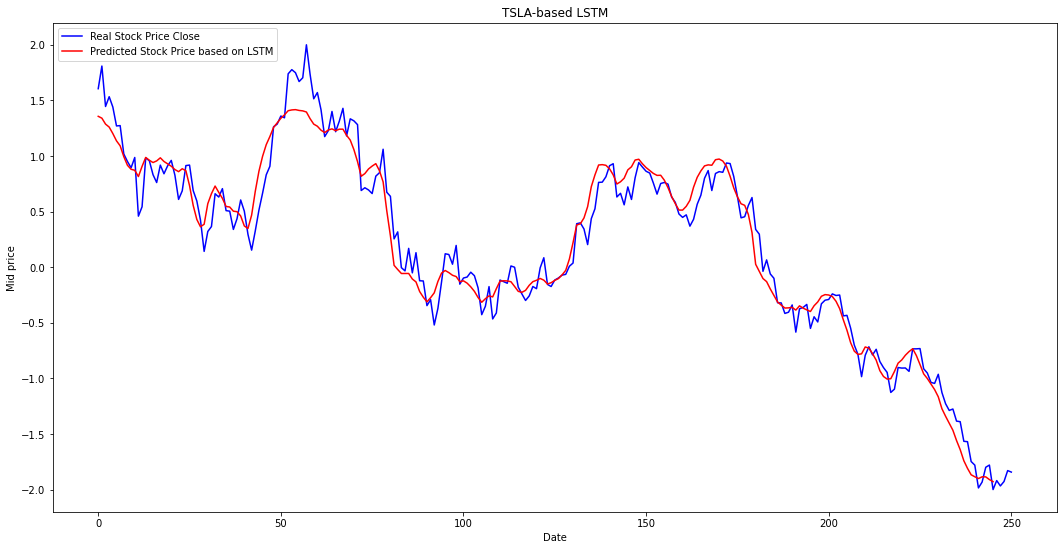

<Figure size 1600x240 with 0 Axes>

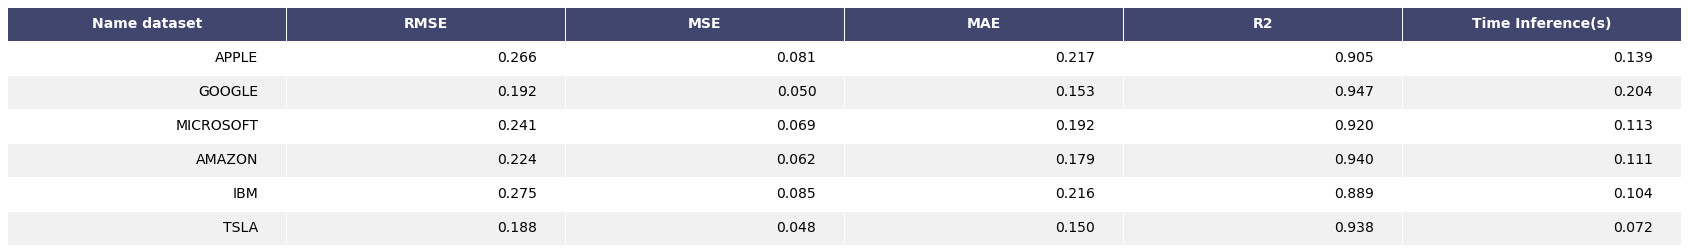

In [ ]:
# Model LSTM

# Vẽ bảng so sánh
myTable = PrettyTable(["Name dataset", "RMSE", "MSE", "MAE", "R2", 'Time Inference(s)'])
for index, name in enumerate(dict_data.keys()):
  myTable.add_row([name, '{:.3f}'.format(list_rmse[index][2]), '{:.3f}'.format(list_mse[index][2]), 
                   '{:.3f}'.format(list_mae[index][2]), '{:.3f}'.format(list_r2[index][2]), 
                   '{:.3f}'.format(list_time_inference[index][2])])
  # Vẽ đồ thị 
  plt.figure(figsize=(18,9))
  plt.plot(list_testing_set[index], 'b-', label='Real Stock Price Close')
  plt.plot(list_y_test[index][2], 'r-', label='Predicted Stock Price based on LSTM')
  plt.title(name + '-based LSTM')
  plt.xlabel('Date')
  plt.ylabel('Mid price')
  plt.legend(loc='upper left')
  plt.savefig(name+'_LSTM.png')
  plt.show()

# the table
plt.figure(figsize=(20, 3), dpi=80)
df = pd.DataFrame.from_records(myTable.rows, columns=myTable.field_names)
df.to_csv('LSTM.csv')
fig,ax = render_mpl_table(df, header_columns=0, col_width=5.0)
fig.savefig("LSTM.png")
# plt.title('Result in testing datasets on LSTM')
# plt.table(cellText=df.values, colLabels=df.columns, loc='center')
plt.show()

#Model CNN2D (Bỏ)

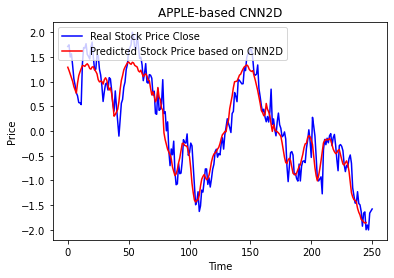

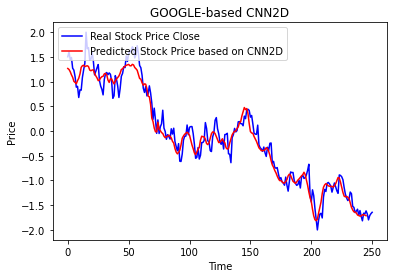

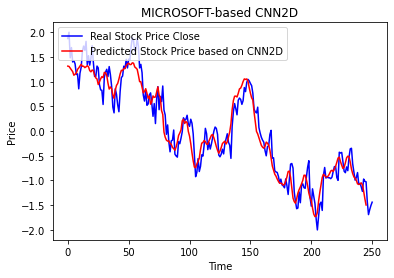

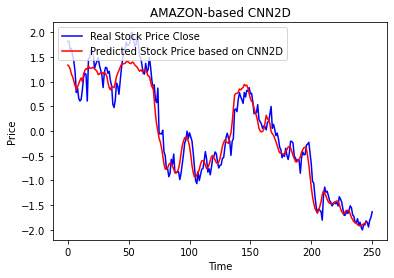

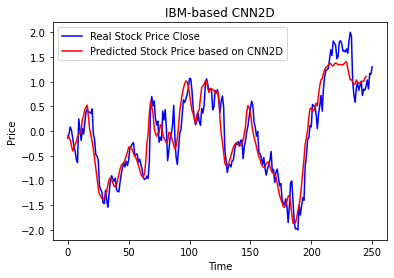

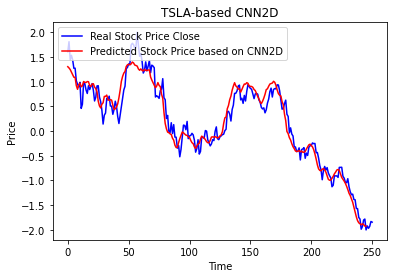

<Figure size 1600x240 with 0 Axes>

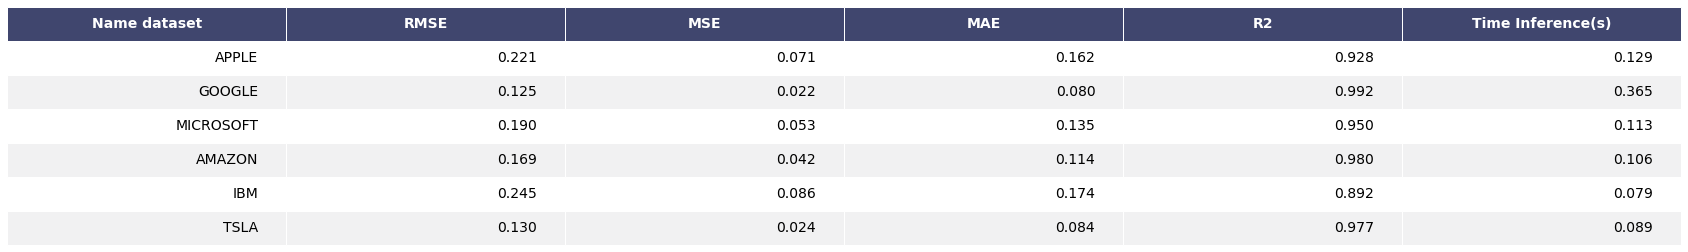

In [ ]:
# Model CNN2D

# Vẽ bảng so sánh
myTable = PrettyTable(["Name dataset", "RMSE", "MSE", "MAE", "R2", 'Time Inference(s)'])
for index, name in enumerate(dict_data.keys()):
  myTable.add_row([name, '{:.3f}'.format(list_rmse[index][0]), '{:.3f}'.format(list_mse[index][0]), 
                   '{:.3f}'.format(list_mae[index][0]), '{:.3f}'.format(list_r2[index][0]), 
                   '{:.3f}'.format(list_time_inference[index][0])])
  # Vẽ đồ thị 
  plt.plot(list_testing_set[index], 'b-', label='Real Stock Price Close')
  plt.plot(list_y_test[index][0], 'r-', label='Predicted Stock Price based on CNN2D')
  plt.title(name + '-based CNN2D')
  plt.xlabel('Time')
  plt.ylabel('Price')
  plt.legend(loc='upper left')
  plt.show()

# the table
plt.figure(figsize=(20, 3), dpi=80)
df = pd.DataFrame.from_records(myTable.rows, columns=myTable.field_names)
df.to_csv('CNN2D.csv')
# print(df)
fig,ax = render_mpl_table(df, header_columns=0, col_width=5.0)
fig.savefig("CNN2D.png")
# plt.title('Result in testing datasets on CNN2D')
# plt.table(cellText=df.values, colLabels=df.columns, loc='center')
plt.show()

# Model BiLSTM

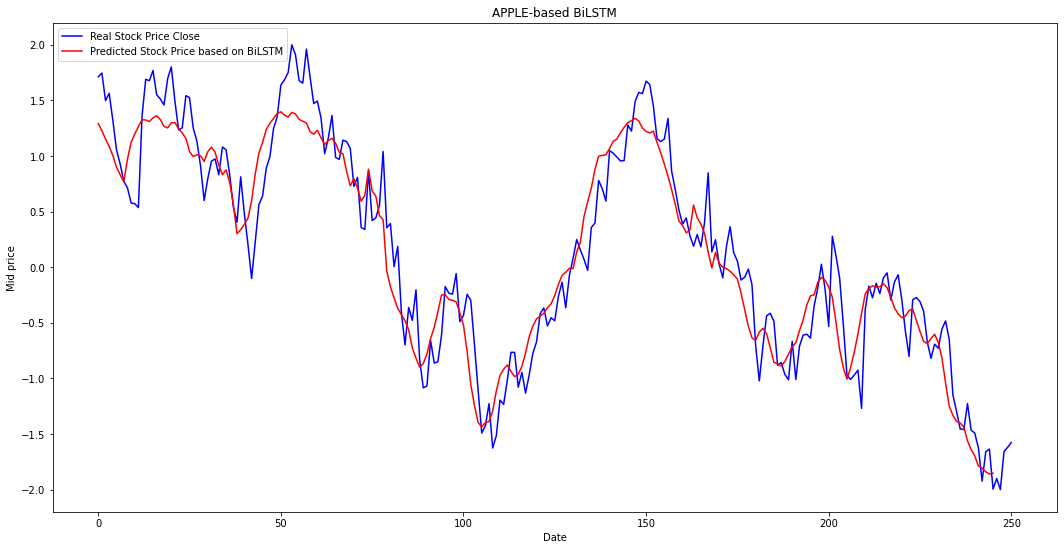

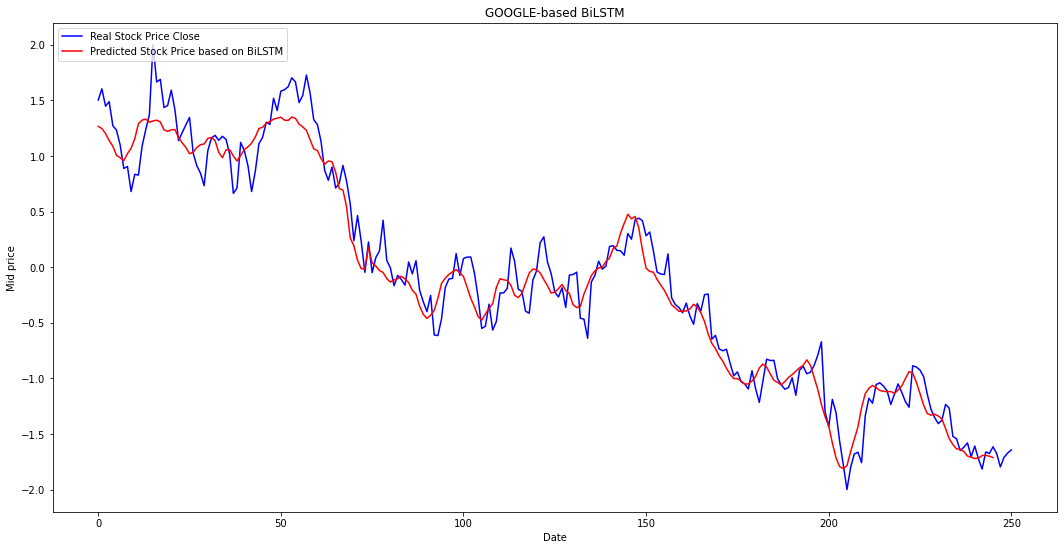

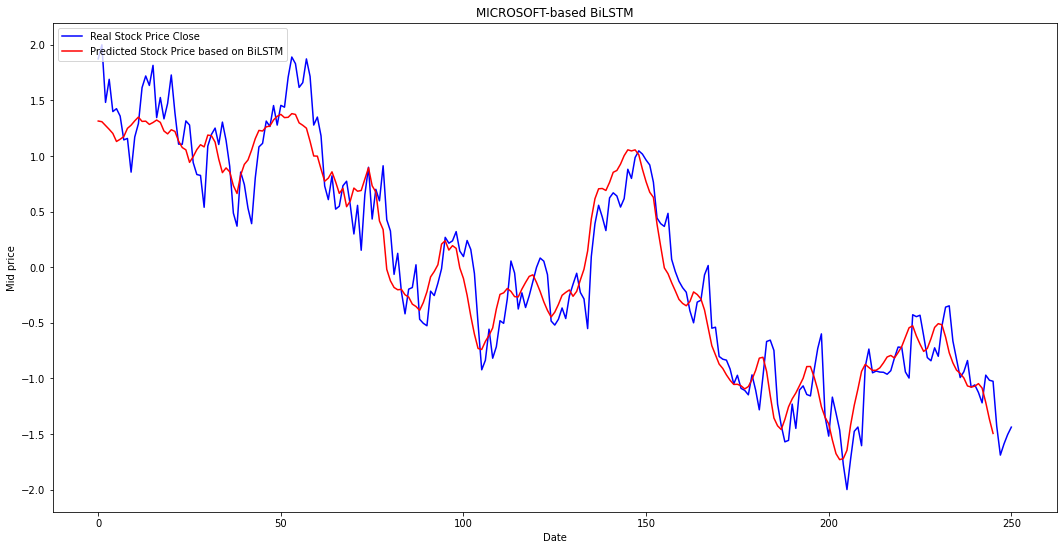

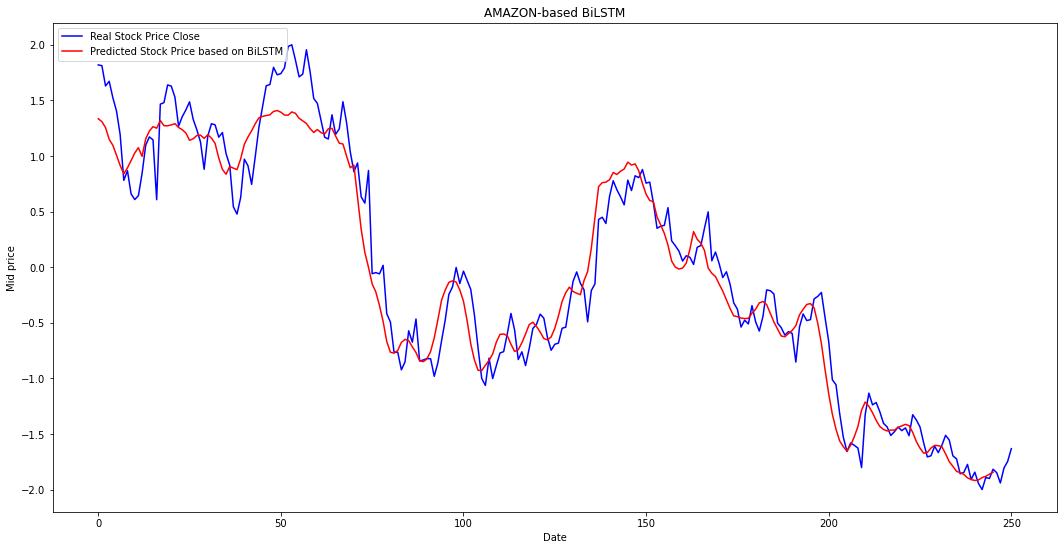

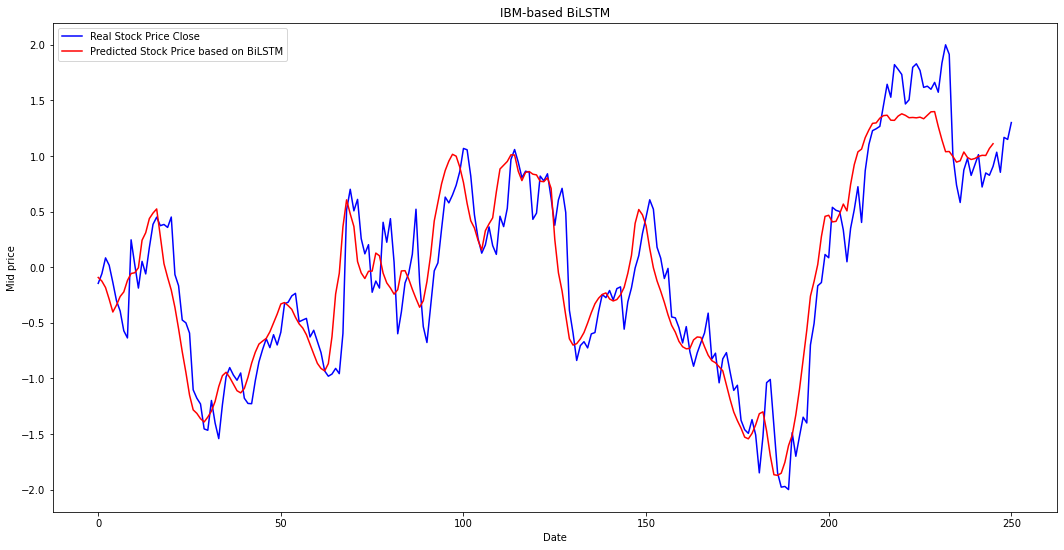

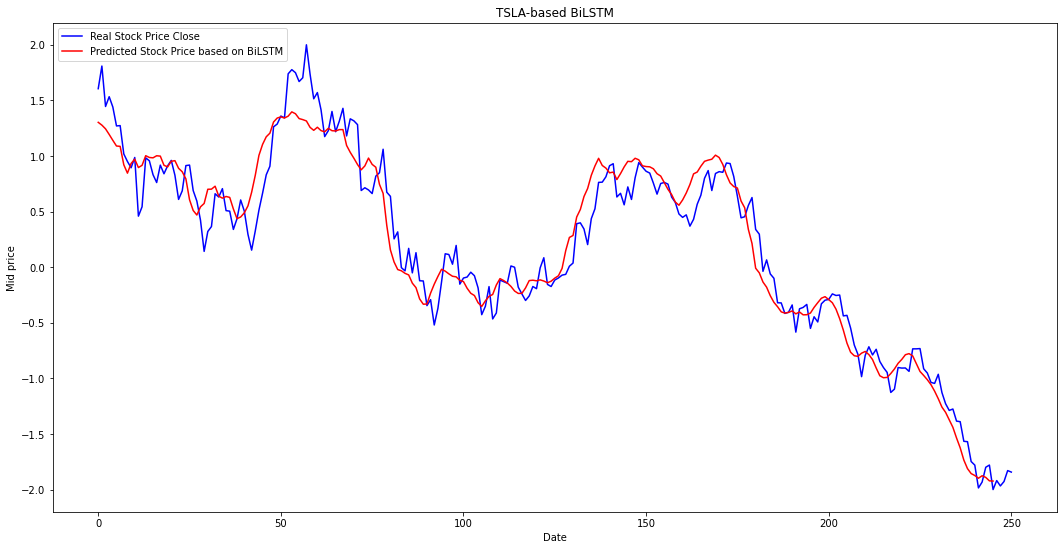

<Figure size 1600x240 with 0 Axes>

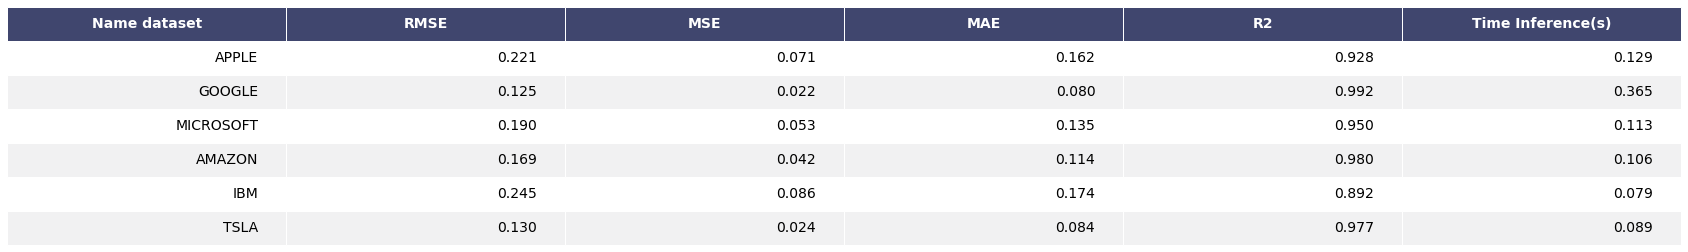

In [ ]:
# Model BiLSTM

# Vẽ bảng so sánh
myTable = PrettyTable(["Name dataset", "RMSE", "MSE", "MAE", "R2", 'Time Inference(s)'])
for index, name in enumerate(dict_data.keys()):
  myTable.add_row([name, '{:.3f}'.format(list_rmse[index][0]), '{:.3f}'.format(list_mse[index][0]), 
                   '{:.3f}'.format(list_mae[index][0]), '{:.3f}'.format(list_r2[index][0]), 
                   '{:.3f}'.format(list_time_inference[index][0])])
  # Vẽ đồ thị 
  plt.figure(figsize=(18,9))
  plt.plot(list_testing_set[index], 'b-', label='Real Stock Price Close')
  plt.plot(list_y_test[index][0], 'r-', label='Predicted Stock Price based on BiLSTM')
  plt.title(name + '-based BiLSTM')
  plt.xlabel('Date')
  plt.ylabel('Mid price')
  plt.legend(loc='upper left')
  plt.savefig(name+'_BiLSTM.png')
  plt.show()

# the table
plt.figure(figsize=(20, 3), dpi=80)
df = pd.DataFrame.from_records(myTable.rows, columns=myTable.field_names)
df.to_csv('BiLSTM.csv')
# print(df)
fig,ax = render_mpl_table(df, header_columns=0, col_width=5.0)
fig.savefig("BiLSTM.png")
plt.show()

# Model CNN2D + BiLSTM

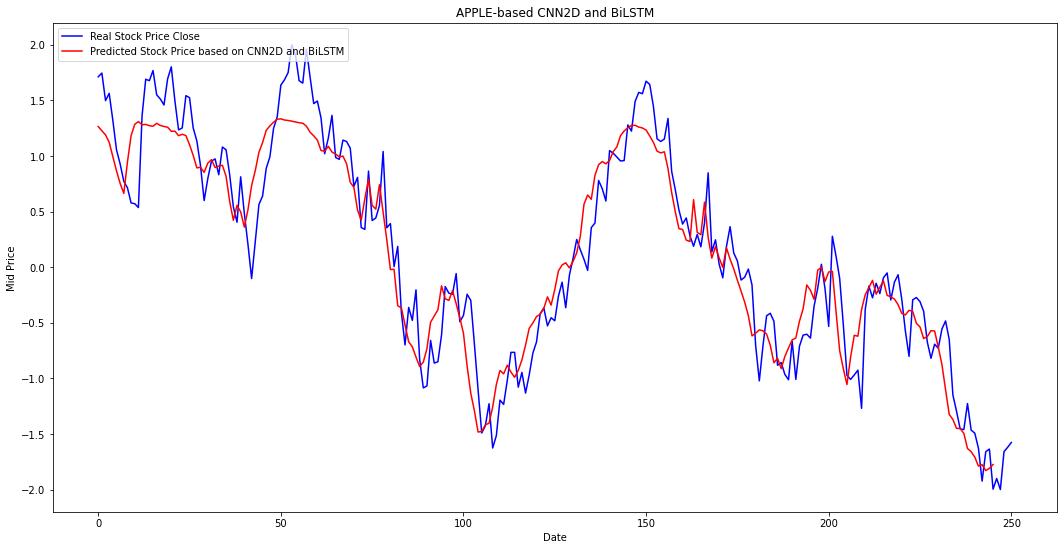

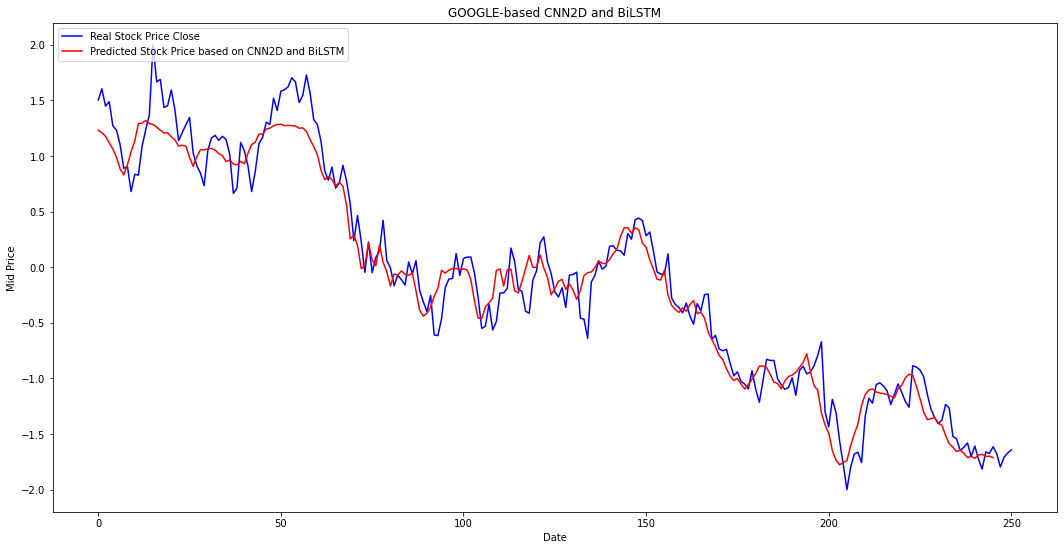

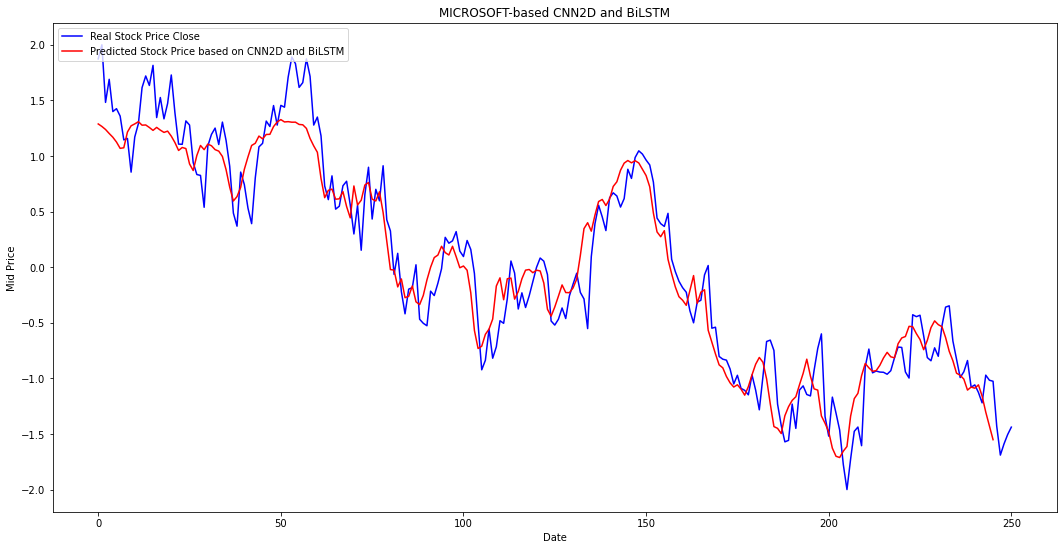

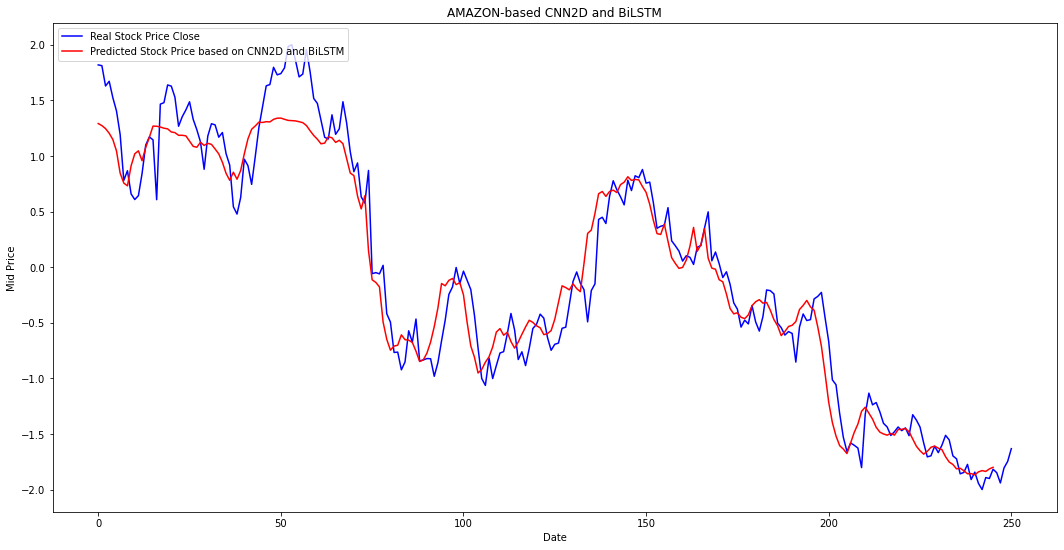

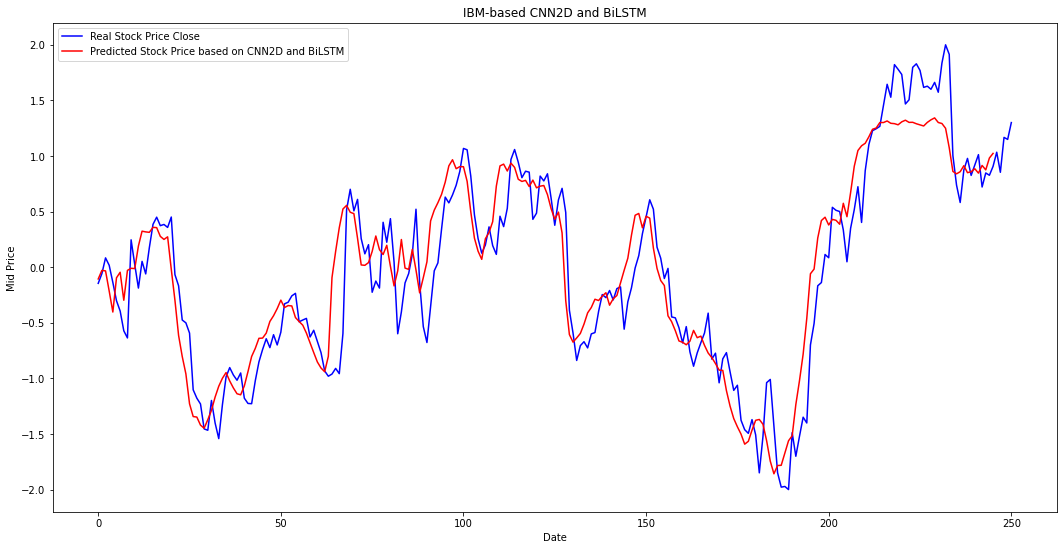

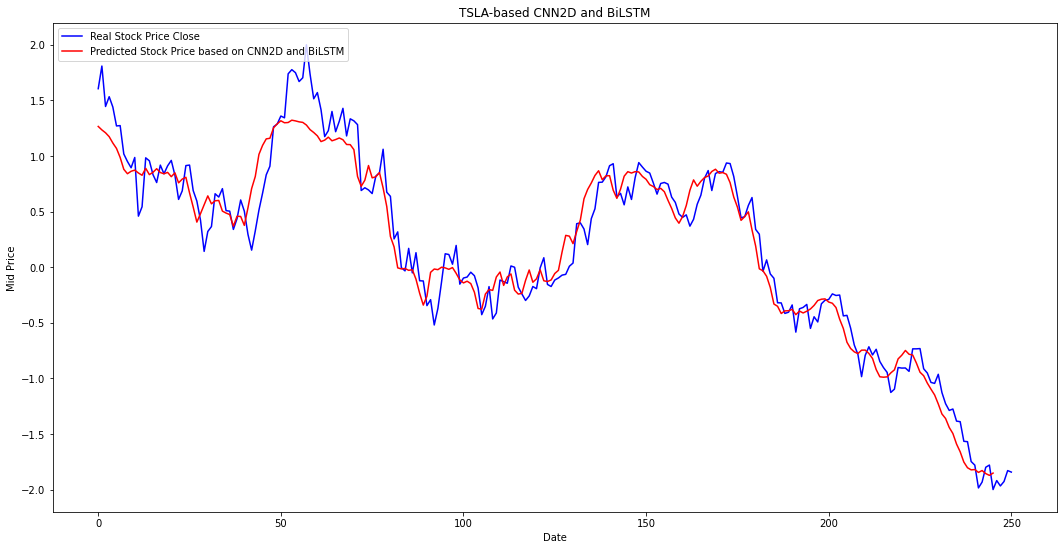

<Figure size 1600x240 with 0 Axes>

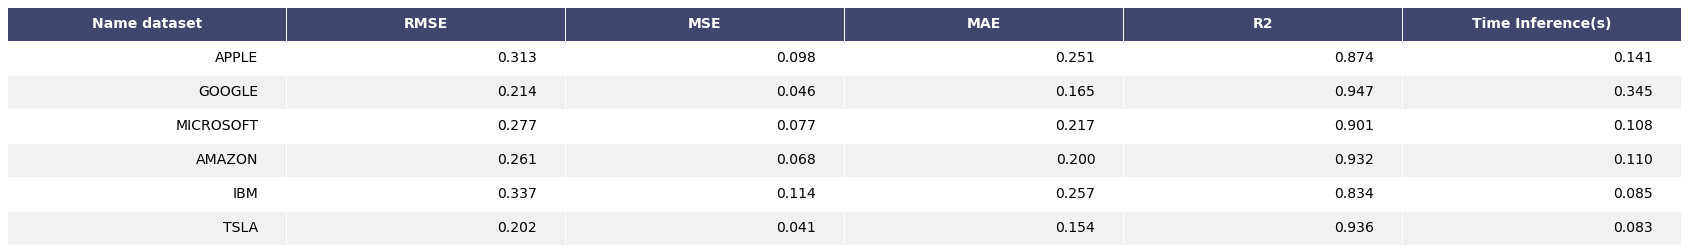

In [ ]:
# Model CNN2D + BiLSTM

# Vẽ bảng so sánh
myTable = PrettyTable(["Name dataset", "RMSE", "MSE", "MAE", "R2", 'Time Inference(s)'])
for index, name in enumerate(dict_data.keys()):
  myTable.add_row([name, '{:.3f}'.format(list_rmse[index][1]), '{:.3f}'.format(list_mse[index][1]), 
                   '{:.3f}'.format(list_mae[index][1]), '{:.3f}'.format(list_r2[index][1]), 
                   '{:.3f}'.format(list_time_inference[index][1])])
  # Vẽ đồ thị 
  plt.figure(figsize=(18,9))
  plt.plot(list_testing_set[index], 'b-', label='Real Stock Price Close')
  plt.plot(list_y_test[index][1], 'r-', label='Predicted Stock Price based on CNN2D and BiLSTM')
  plt.title(name + '-based CNN2D and BiLSTM')
  plt.xlabel('Date')
  plt.ylabel('Mid Price')
  plt.legend(loc='upper left')
  plt.savefig(name+'_CNN2D_BiLSTM.png')
  plt.show()

# the table
plt.figure(figsize=(20, 3), dpi=80)
df = pd.DataFrame.from_records(myTable.rows, columns=myTable.field_names)
df.to_csv('CNN2D_BiLSTM.csv')
fig,ax = render_mpl_table(df, header_columns=0, col_width=5.0)
fig.savefig("CNN2D_BiLSTM.png")
plt.show()

# Phân tích dữ liệu

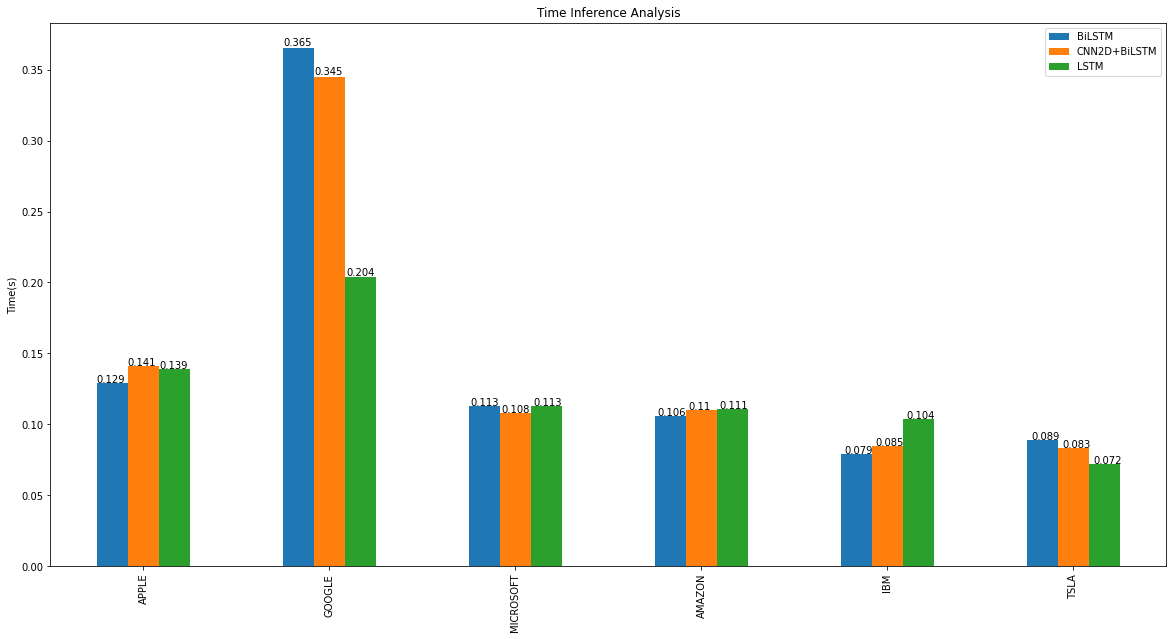

In [ ]:
# Phân tích time inference
list_time_inference = np.around(np.array(list_time_inference), decimals=3)
column_values = ['BiLSTM', 'CNN2D+BiLSTM', 'LSTM']
index = dict_data.keys()
df_time = pd.DataFrame(data=list_time_inference, columns=column_values, index=index)
ax = df_time.plot(kind='bar', title='Time Inference Analysis', figsize=(20,10))
ax.set_ylabel("Time(s)") 
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.get_figure().savefig('time_inference.png')

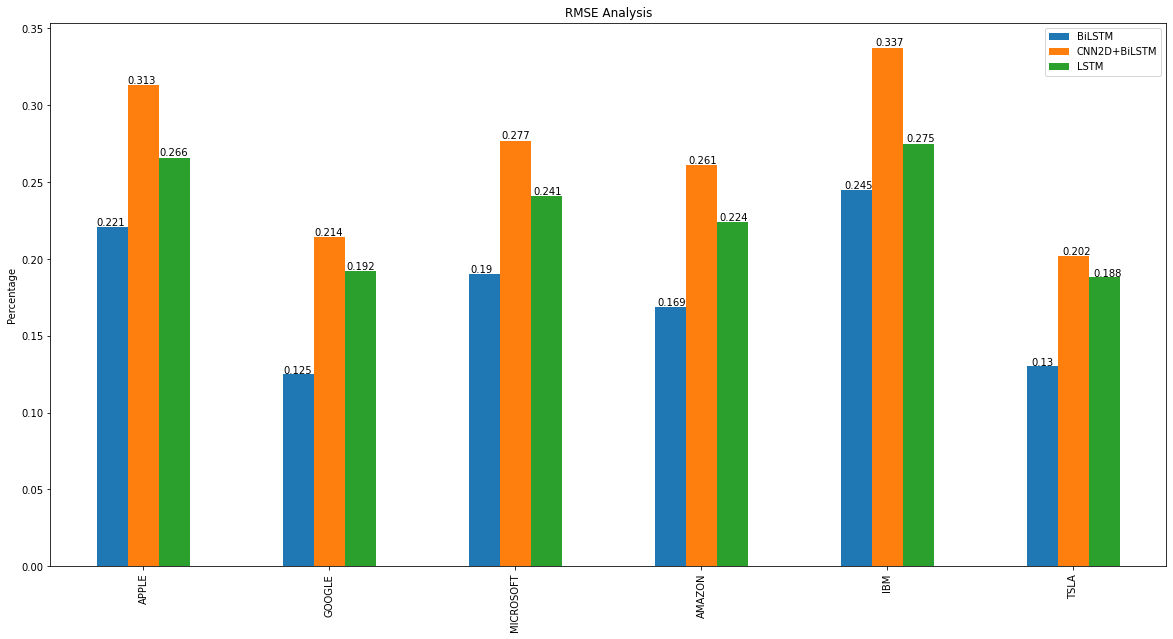

In [ ]:
# Phân tích RMSE
list_rmse = np.around(np.array(list_rmse), decimals=3)
column_values = ['BiLSTM', 'CNN2D+BiLSTM', 'LSTM']
index = dict_data.keys()
df_rmse = pd.DataFrame(data=list_rmse, columns=column_values, index=index)
ax = df_rmse.plot(kind='bar', title='RMSE Analysis', figsize=(20,10)) 
ax.set_ylabel('Percentage')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.get_figure().savefig('rmse.png')

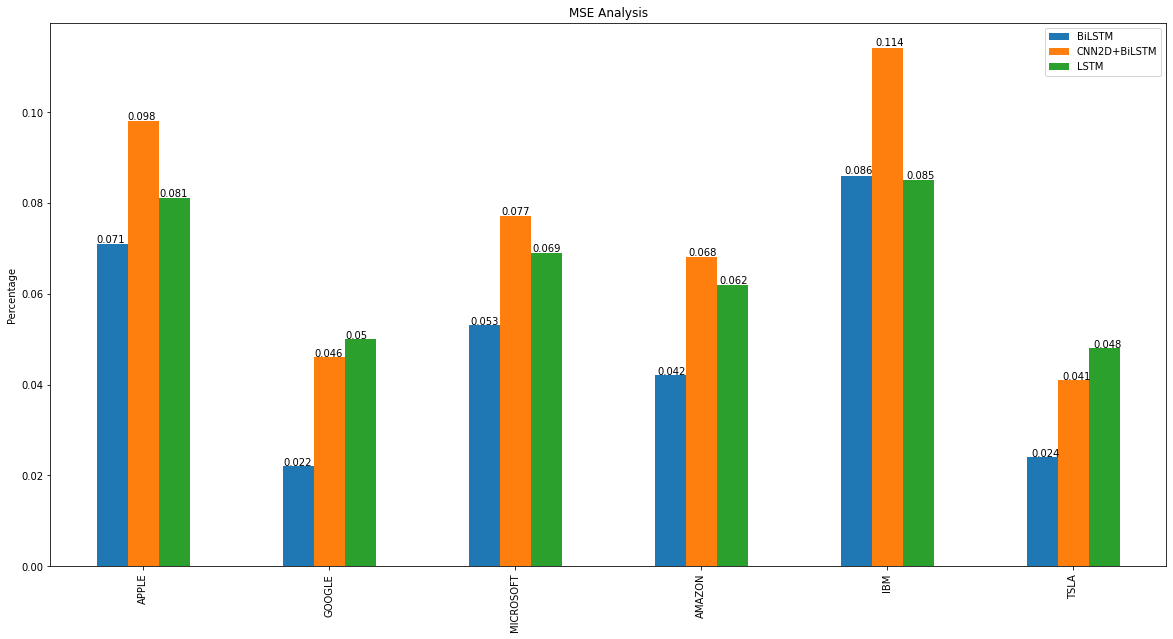

In [ ]:
# Phân tích MSE
list_mse = np.around(np.array(list_mse), decimals=3)
column_values = ['BiLSTM', 'CNN2D+BiLSTM', 'LSTM']
index = dict_data.keys()
df_mse = pd.DataFrame(data=list_mse, columns=column_values, index=index)
ax = df_mse.plot(kind='bar', title='MSE Analysis', figsize=(20,10)) 
ax.set_ylabel('Percentage')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.get_figure().savefig('mse.png')

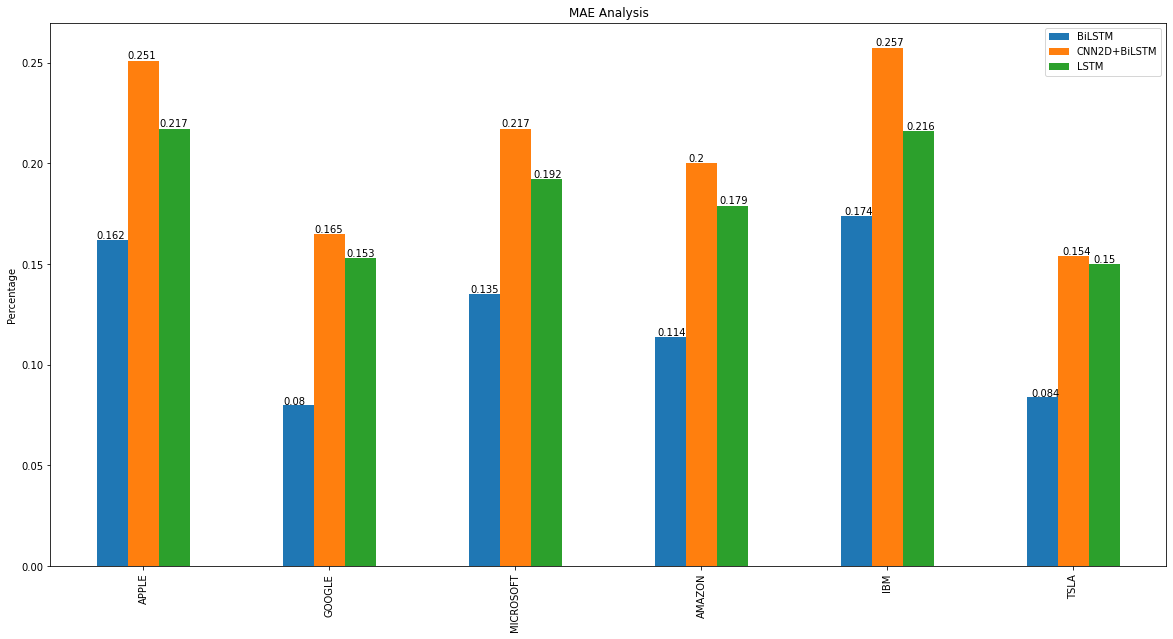

In [ ]:
# Phân tích MAE
list_mae = np.around(np.array(list_mae), decimals=3)
column_values = ['BiLSTM', 'CNN2D+BiLSTM', 'LSTM']
index = dict_data.keys()
df_mae = pd.DataFrame(data=list_mae, columns=column_values, index=index)
ax = df_mae.plot(kind='bar', title='MAE Analysis', figsize=(20,10)) 
ax.set_ylabel('Percentage')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.get_figure().savefig('mae.png')

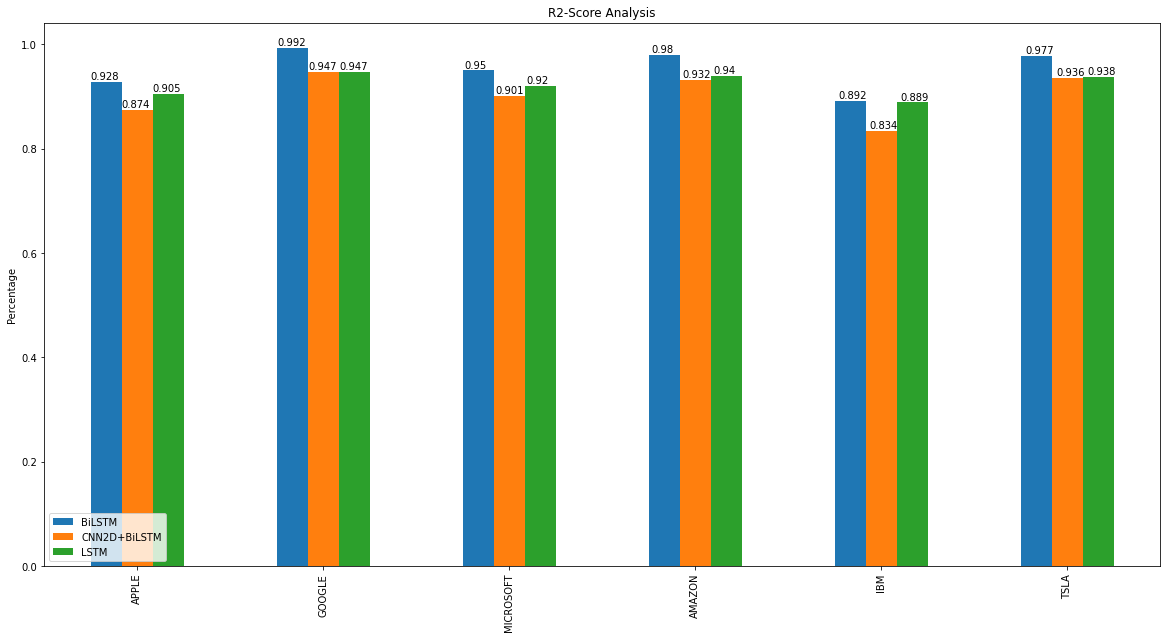

In [ ]:
# Phân tích R2-Score
list_r2 = np.around(np.array(list_r2), decimals=3)
column_values = ['BiLSTM', 'CNN2D+BiLSTM', 'LSTM']
index = dict_data.keys()
df_r2 = pd.DataFrame(data=list_r2, columns=column_values, index=index)
ax = df_r2.plot(kind='bar', title='R2-Score Analysis', figsize=(20,10)) 
plt.legend(loc='lower left')
ax.set_ylabel('Percentage')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.get_figure().savefig('r2.png')